In [10]:
import numpy as np
from ddm_utils import *
import matplotlib.pyplot as plt
from joblib import Parallel, delayed
from numba import jit
from scipy import integrate
import pickle
import plotly.graph_objects as go


In [2]:
# params
bound_arr = np.array([2,10]); velocity_arr = np.array([-4,-3,-2,-1,0,1,2,3,4])

# Small and Big coincide for long time - Hence using only small

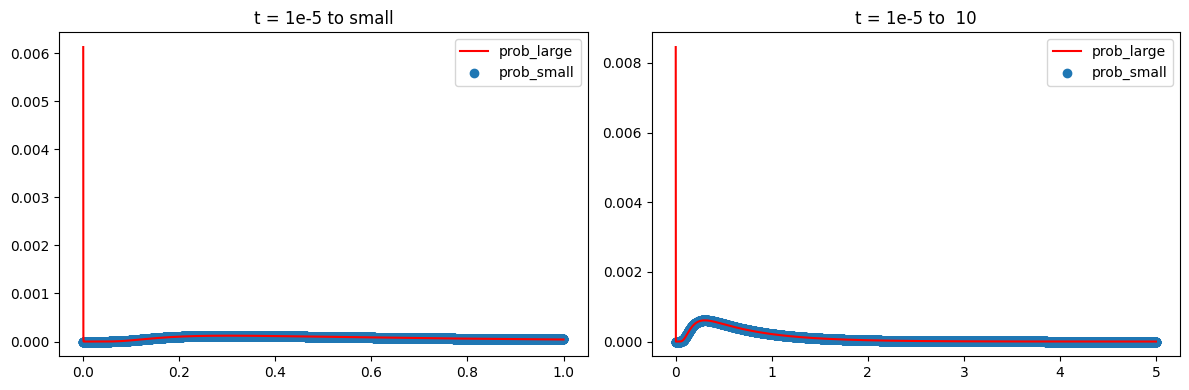

In [3]:
fig, axs = plt.subplots(1, 2, figsize=(12, 4))

# Left plot
t_pts = np.linspace(0.00001, 1, 10000)
v = 1; a = 2; theta = a / 2; mu = theta * v
prob_large = prob_rt_generic(t_pts, mu, rtd_mu_large_t)
prob_small = prob_rt_generic(t_pts, mu, rtd_mu_small_t)
axs[0].plot(t_pts[:-1], prob_large, label='prob_large', color='red')
axs[0].scatter(t_pts[:-1], prob_small, label='prob_small')
axs[0].legend()
axs[0].set_title('t = 1e-5 to small')

# Right plot
t_pts = np.linspace(0.00001, 5, 10000)
prob_large = prob_rt_generic(t_pts, mu, rtd_mu_large_t)
prob_small = prob_rt_generic(t_pts, mu, rtd_mu_small_t)
axs[1].plot(t_pts[:-1], prob_large, label='prob_large', color='red')
axs[1].scatter(t_pts[:-1], prob_small, label='prob_small')
axs[1].legend()
axs[1].set_title('t = 1e-5 to  10')

plt.tight_layout()
plt.show()


# Generating Data

In [ ]:
N_sim = 50000;all_sim_results = {}
for a in bound_arr:
    for v in velocity_arr:
        # if a == 10 and v == 0:
        #     continue
        keyname = f"a={str(a)},v={str(v)}"
        sim_results = Parallel(n_jobs=-1)(delayed(simulate_ddm)(v, a) for _ in range(N_sim))
        all_sim_results[keyname] = sim_results

        print('completed ', keyname)

with open('all_sim_results.pkl', 'wb') as f:
    pickle.dump(all_sim_results, f)

# Reading data

In [4]:
with open('all_sim_results.pkl', 'rb') as f:
    all_sim_results = pickle.load(f)

# With mu expression: a = 2 and 10

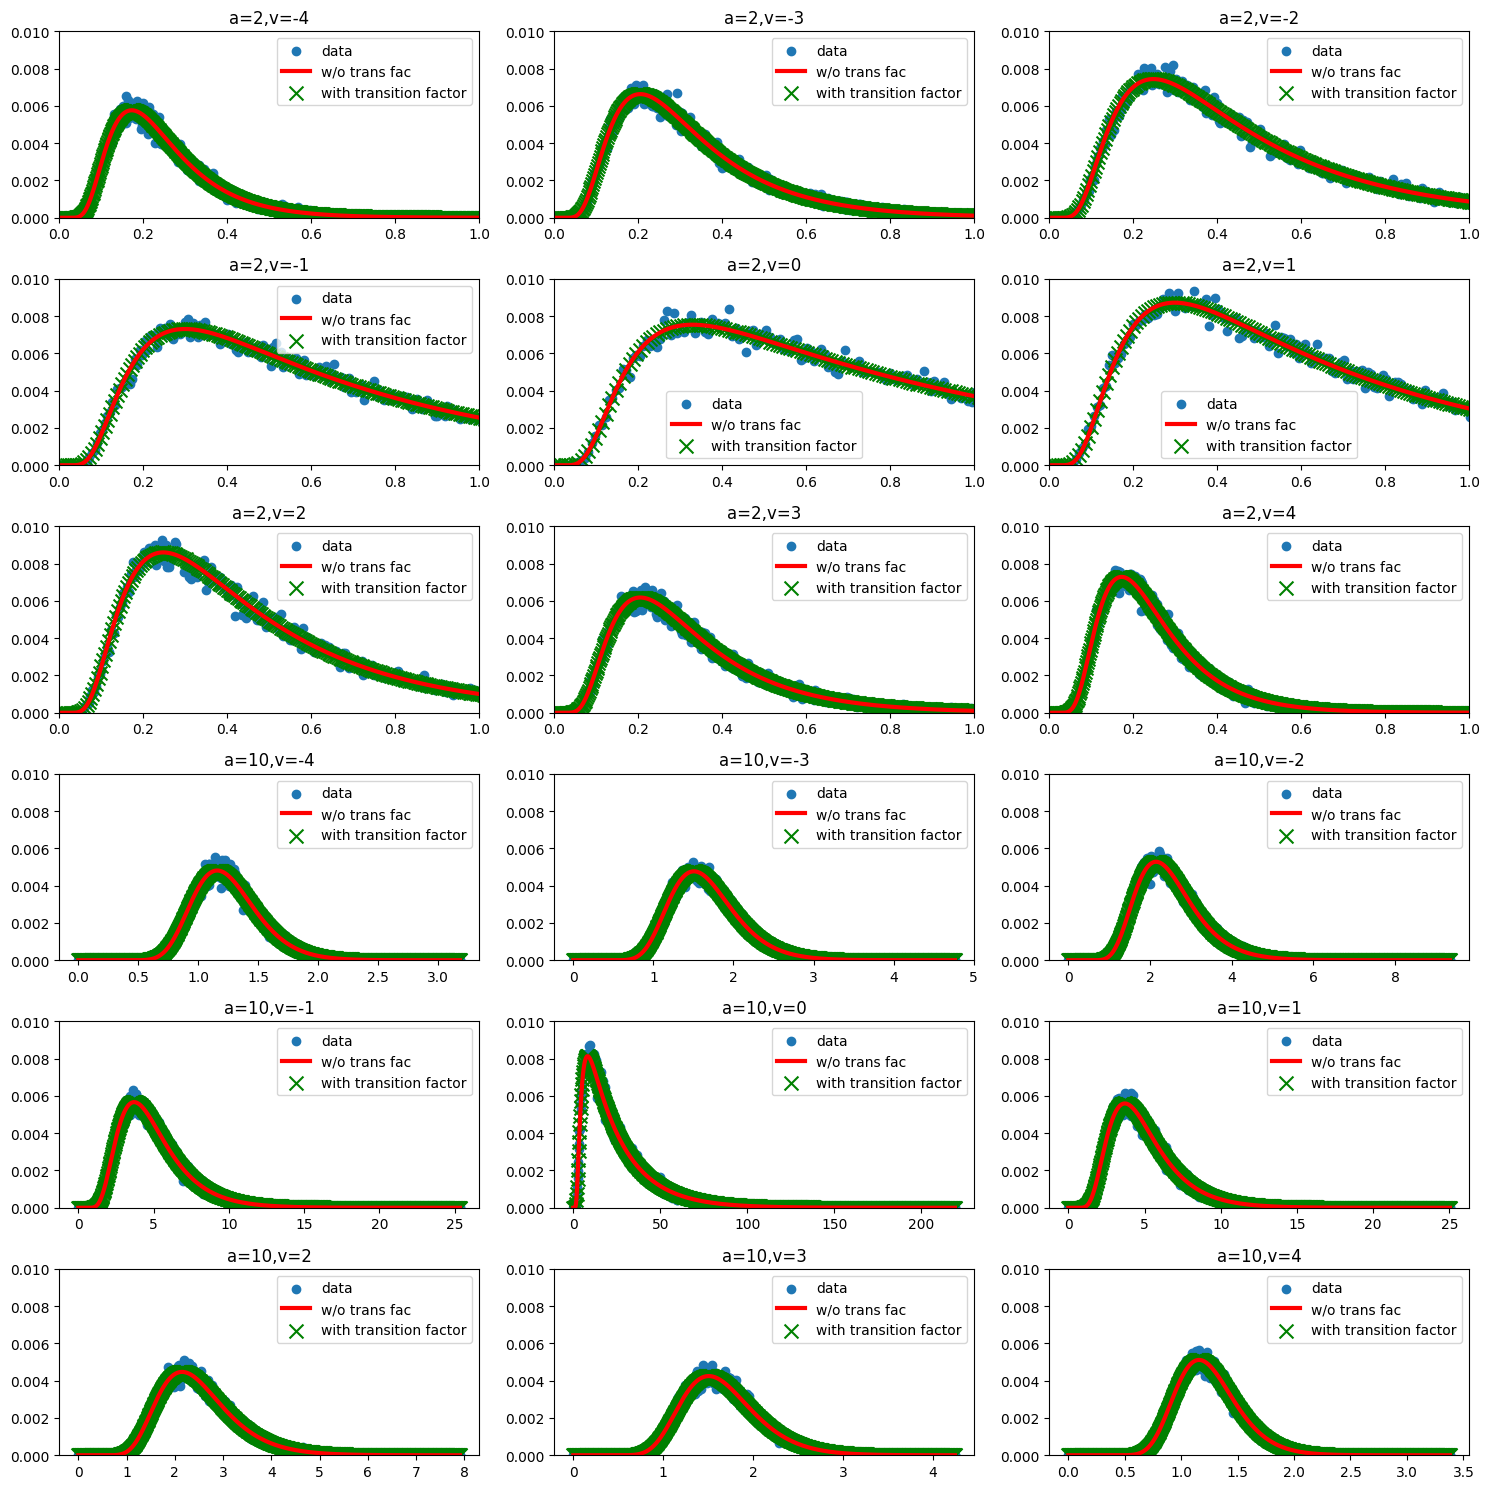

In [13]:
w = 0.5; 
fig, axes = plt.subplots(6, 3, figsize=(15, 15))
i = 0
for a in bound_arr:
    for v in velocity_arr:
        if a == 2:
            smol_2_large_trans = 0.25
        elif a == 10:
            smol_2_large_trans = 0.005

        mu = (a/2)*v
        t_scale = (a**2)/4

        
        keyname = f"a={str(a)},v={str(v)}"
        choices, RTs = parse_sim_results(all_sim_results[keyname])        
        
        t_pts = np.linspace(0.0001/t_scale, max(RTs)/t_scale, 1000)
        
        
        prob = calculate_histogram(t_pts*t_scale, RTs)
        RT_theory_1 = prob_rt_mu(t_pts, mu, smol_2_large_trans)
        RT_theory = prob_rt_generic(t_pts, mu, rtd_mu_small_t)
        
        
        axes[i//3, i%3].scatter(t_pts[:-1]*t_scale, prob); 
        axes[i//3, i%3].plot(t_pts[:-1]*t_scale, RT_theory,linewidth=3, color='red');
        axes[i//3, i%3].scatter(t_pts[:-1]*t_scale, RT_theory_1, color='green', marker='x', **{'s': 100});

        if a == 2:
            axes[i//3, i%3].set_xlim([0, 1])
            axes[i//3, i%3].set_ylim([0, 0.01])
        elif a == 10:
            axes[i//3, i%3].set_ylim([0, 0.01])


        axes[i//3, i%3].set_title(keyname); 
        axes[i//3, i%3].legend(['data', 'w/o trans fac', 'with transition factor'])
        i += 1

plt.tight_layout()
plt.show()


# For a = 10: `rt_up + rt_low`



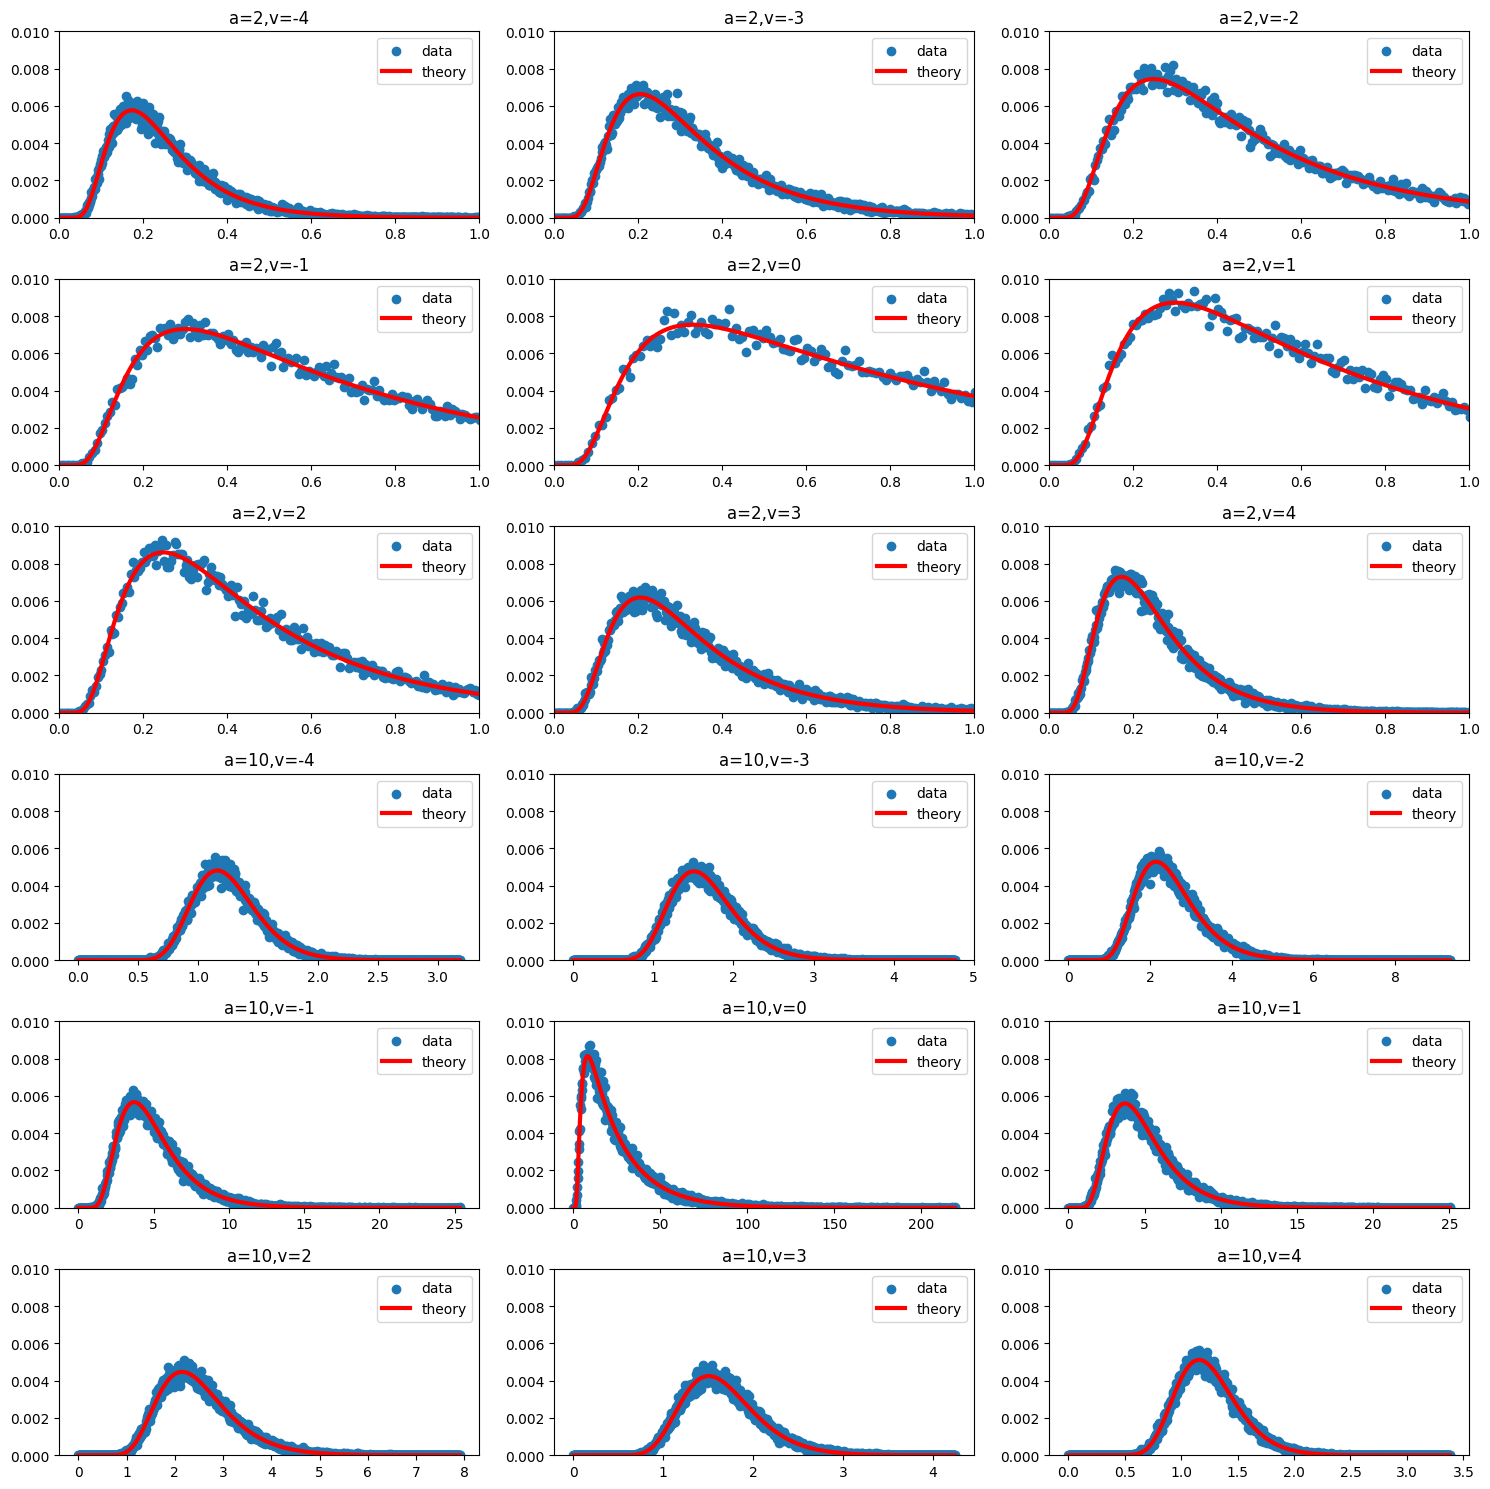

In [14]:
w = 0.5; K_max = 100
fig, axes = plt.subplots(6, 3, figsize=(15, 15))
i = 0
for a in bound_arr:
    for v in velocity_arr:
        keyname = f"a={str(a)},v={str(v)}"
        choices, RTs = parse_sim_results(all_sim_results[keyname])        
        
        t_pts = np.linspace(0.0001, max(RTs), 1000)
        prob = calculate_histogram(t_pts, RTs)
        RT_theory = prob_rt_a(t_pts, v, a, w) + prob_rt_a(t_pts, -v, a, 1-w)

        axes[i//3, i%3].scatter(t_pts[:-1], prob); 
        axes[i//3, i%3].plot(t_pts[:-1], RT_theory,linewidth=3, color='red');
        axes[i//3, i%3].set_title(keyname); 
        axes[i//3, i%3].legend(['data', 'theory'])

        if a == 2:
            axes[i//3, i%3].set_xlim([0, 1])
            axes[i//3, i%3].set_ylim([0, 0.01])
        elif a == 10:
            axes[i//3, i%3].set_ylim([0, 0.01])
            
        i += 1

plt.tight_layout()
plt.show()


# Fitting Choice

In [5]:
w = 0.5
prob_r_a_v = np.zeros((len(bound_arr), len(velocity_arr)))
count_r_data = np.zeros((len(bound_arr), len(velocity_arr)))
for i,a in enumerate(bound_arr):
    for j,v in enumerate(velocity_arr):
        prob_r_a_v[i,j] = 1 - prob_hit_low_bound(v,a,w)

        keyname = f"a={str(a)},v={str(v)}"
        choices, RTs = parse_sim_results(all_sim_results[keyname])
        # if a == 2:
        #     print(choices.count(1), len(choices))
        count_r_data[i,j] = choices.count(1)

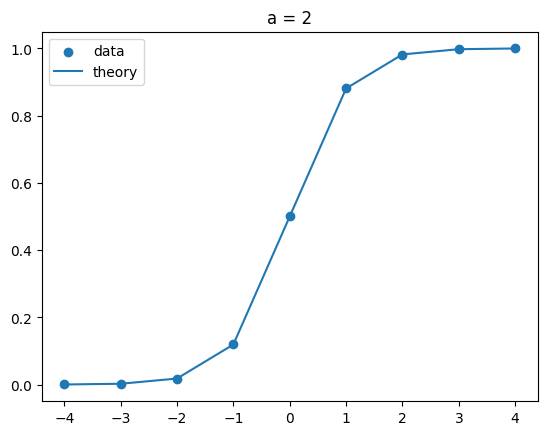

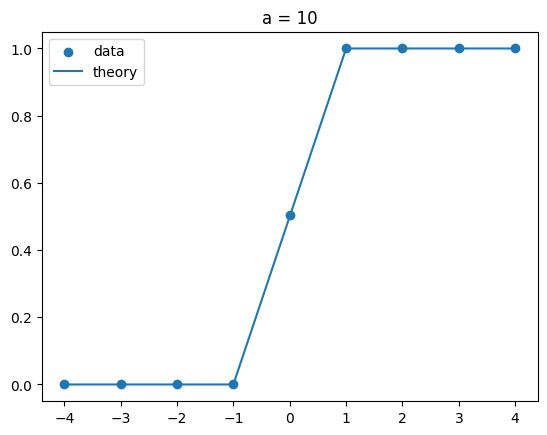

In [35]:
plt.figure()
plt.scatter(velocity_arr,count_r_data[0,:]/N_sim); plt.plot(velocity_arr, prob_r_a_v[0,:]); plt.title('a = 2'); plt.legend((['data', 'theory']));
plt.figure()
plt.scatter(velocity_arr,count_r_data[1,:]/N_sim); plt.plot(velocity_arr, prob_r_a_v[1,:]); plt.title('a = 10'); plt.legend((['data', 'theory']));

# theoretical curve can be continuous

In [11]:
v_x = np.linspace(-4,4,1000);a=10
prob_of_right_theory = np.zeros((2, len(v_x)))
prob_of_right_theory[0,:] = [1 - prob_hit_low_bound(v_,2,0.5) for v_ in v_x]
prob_of_right_theory[1,:] = [1 - prob_hit_low_bound(v_,a,0.5) for v_ in v_x]

In [12]:
v_x[prob_of_right_theory[0,:] > 0.9]

array([1.1011011 , 1.10910911, 1.11711712, 1.12512513, 1.13313313,
       1.14114114, 1.14914915, 1.15715716, 1.16516517, 1.17317317,
       1.18118118, 1.18918919, 1.1971972 , 1.20520521, 1.21321321,
       1.22122122, 1.22922923, 1.23723724, 1.24524525, 1.25325325,
       1.26126126, 1.26926927, 1.27727728, 1.28528529, 1.29329329,
       1.3013013 , 1.30930931, 1.31731732, 1.32532533, 1.33333333,
       1.34134134, 1.34934935, 1.35735736, 1.36536537, 1.37337337,
       1.38138138, 1.38938939, 1.3973974 , 1.40540541, 1.41341341,
       1.42142142, 1.42942943, 1.43743744, 1.44544545, 1.45345345,
       1.46146146, 1.46946947, 1.47747748, 1.48548549, 1.49349349,
       1.5015015 , 1.50950951, 1.51751752, 1.52552553, 1.53353353,
       1.54154154, 1.54954955, 1.55755756, 1.56556557, 1.57357357,
       1.58158158, 1.58958959, 1.5975976 , 1.60560561, 1.61361361,
       1.62162162, 1.62962963, 1.63763764, 1.64564565, 1.65365365,
       1.66166166, 1.66966967, 1.67767768, 1.68568569, 1.69369

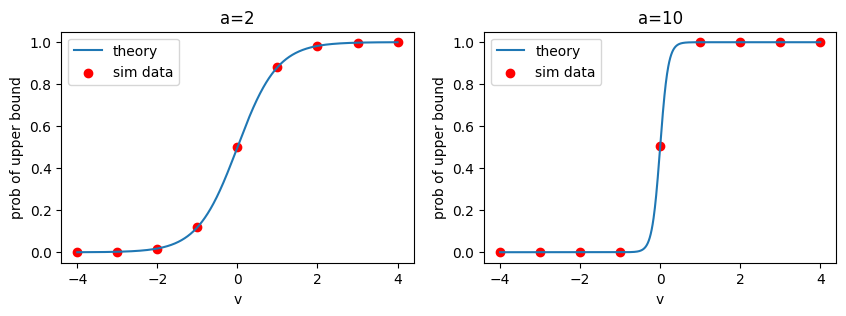

In [14]:
plt.figure(figsize=(10,3))
plt.subplot(1,2,1)
plt.plot(v_x,prob_of_right_theory[0,:]);plt.xlabel('v'); plt.ylabel('prob of upper bound');plt.title('a=2');
plt.scatter(velocity_arr,count_r_data[0,:]/50e3, color='red');plt.legend(['theory', 'sim data'])
plt.subplot(1,2,2)
plt.plot(v_x,prob_of_right_theory[1,:]);plt.xlabel('v'); plt.ylabel('prob of upper bound');plt.title('a=10');
plt.scatter(velocity_arr,count_r_data[1,:]/50e3, color='red');plt.legend(['theory', 'sim data']);

# chronometric funcs

In [3]:
with open('all_sim_results.pkl', 'rb') as f:
    all_sim_results = pickle.load(f)

In [8]:
mean_rt_vs_v = np.zeros((2,9))

In [9]:
for i,a in enumerate(bound_arr):
    for j,v in enumerate(velocity_arr):
        keyname = f"a={str(a)},v={str(v)}"
        choices, RTs = parse_sim_results(all_sim_results[keyname])        
        
        mean_rt_vs_v[i,j] = np.mean(RTs)
        

Text(0.5, 1.0, 'Mean RT vs Velocity a = 10')

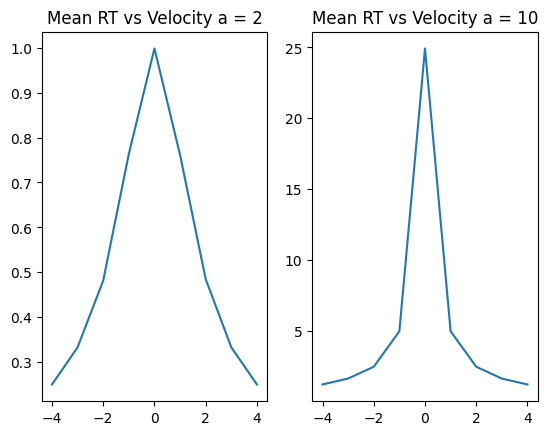

In [15]:
plt.subplot(1,2,1)
plt.plot(velocity_arr,mean_rt_vs_v[0,:]);plt.title('Mean RT vs Velocity a = 2')
plt.subplot(1,2,2)
plt.plot(velocity_arr,mean_rt_vs_v[1,:]);plt.title('Mean RT vs Velocity a = 10')

Text(0.5, 1.0, 'Mean RT vs Velocity a = 10')

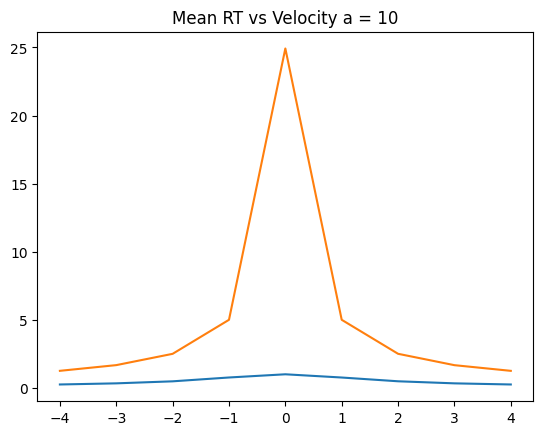

In [16]:
plt.plot(velocity_arr,mean_rt_vs_v[0,:]);plt.title('Mean RT vs Velocity a = 2')
plt.plot(velocity_arr,mean_rt_vs_v[1,:]);plt.title('Mean RT vs Velocity a = 10')